In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import astropy.units as u
import numpy as np
import tracemalloc
import time
import matplotlib.pyplot as plt
from scipy import special
import os.path

In [2]:
def guillot_pt(Teq, T_int,grav, logg1, logKir, alpha,nlevel, p_bottom, p_top):
    kv1, kv2 =10.**(logg1+logKir),10.**(logg1+logKir)
    kth=10.**logKir

    Teff = T_int
    f = 1.0  # solar re-radiation factor
    A = 0.0  # planetary albedo
    g0 = grav #cm/s2 to m/s2

    # Compute equilibrium temperature and set up gamma's
    T0 = Teq
    gamma1 = kv1/kth #Eqn. 25
    gamma2 = kv2/kth

    # Initialize arrays
    logtau =np.arange(-10,20,.1)
    tau =10**logtau

    #computing temperature
    T4ir = 0.75*(Teff**(4.))*(tau+(2.0/3.0))
    f1 = 2.0/3.0 + 2.0/(3.0*gamma1)*(1.+(gamma1*tau/2.0-1.0)*np.exp(-gamma1*tau))+2.0*gamma1/3.0*(1.0-tau**2.0/2.0)*special.expn(2.0,gamma1*tau)
    f2 = 2.0/3.0 + 2.0/(3.0*gamma2)*(1.+(gamma2*tau/2.0-1.0)*np.exp(-gamma2*tau))+2.0*gamma2/3.0*(1.0-tau**2.0/2.0)*special.expn(2.0,gamma2*tau)

    T4v1=f*0.75*T0**4.0*(1.0-alpha)*f1
    T4v2=f*0.75*T0**4.0*alpha*f2
    T=(T4ir+T4v1+T4v2)**(0.25)
    P=tau*g0/(kth*0.1)/1.E5

    logP = np.linspace(p_top,p_bottom,nlevel)
    newP = 10.0**logP
    T = np.interp(logP,np.log10(P),T)
    
    return T   

In [3]:
def run_planet(T_int,grav,a,T_star,logg,metal,rstar,mh,CtoO,rfacv):
    mh = mh
    CtoO = CtoO

    filename_db="/Users/sagnickmukherjee/Documents/GitHub/picaso-dev/reference/opacities/ck_cx_cont_opacities.db"
    ck_db='/Users/sagnickmukherjee/Documents/software/picaso-dev/reference/opacities/ck_db/m'+mh+'_co'+CtoO+'.data.196'

    
    path = "/Users/sagnickmukherjee/Documents/research/geers/wasp39b"
    file_path= path+"/tpfile/tp_eq_planet_"+str(T_int)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_1.5_sm_"+str(a)+"_v_"+str(0.5)+"_.dat"
    pressure,temp_guess = np.loadtxt(file_path,usecols=[0,1],unpack=True)
    
    opacity_ck = jdi.opannection(ck=True, ck_db=ck_db,filename_db=filename_db)#, deq = True, first_deq = True)


    # planet prop
    semi_major = a #0.0355 #"NA" # AU
    T_eff = T_int
    grav = grav
    r_planet = 1 # needed for vulcan photochem runs

    ### star prop
    T_star = T_star
    logg = logg
    metal = metal
    r_star = rstar




    nlevel = 91
    #pressure=np.logspace(np.log10(1e-6),np.log10(200.0),nlevel)
    #temp_guess = np.zeros(shape=(nlevel)) 
    kz = np.zeros(shape =(nlevel))
    #pressure_dummy,temp_guess,t1,t2,t3,t4 = np.loadtxt("/data/users/samukher/Disequilibrium-picaso/structures_m+0.0/t"+str(round(600/100.0)*100)+"g"+str(31)+"nc_m0.0.dat",usecols=[1,2,3,4,5,6],unpack=True, skiprows = 1)
    #Teq = T_star*np.sqrt(rstar/(2*semi_major*216))
    #temp_guess = guillot_pt(Teq=Teq, T_int=T_int,grav=grav, logg1=-1, logKir=-1.5, alpha=0.5,nlevel=91, p_bottom = np.log10(np.max(pressure)), p_top =np.log10(np.min(pressure)))

    #pdummy,temp_guess = np.loadtxt(path+"tpfile/tp_eq_planet_200_grav_4.5_mh_+0.0_CO_0.5_sm_0.0486_v_0.5_.dat",usecols=[0,1],unpack=True)
    
    nofczns = 1
    
    nstr = np.array([0,78,89,0,0,0])
    rfacv = rfacv
    rfaci =1.0
    cloudy = True
    fsed = 3
    species = ['MnS','MgSiO3','Na2S']



    ###### run start

    cl_run = jdi.inputs(calculation="planet", climate = True)

    cl_run.star(opacity_ck, temp =T_star,metal =metal, logg =logg, radius = r_star, radius_unit=u.R_sun,semi_major= semi_major , semi_major_unit = u.AU)#opacity db, pysynphot database, temp, metallicity, logg

    cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)'))
    cl_run.T_eff(Teff=T_eff)





    cl_run.inputs_climate(temp_guess= temp_guess, pressure= pressure, nstr = nstr, nofczns = nofczns , rfacv = rfacv, rfaci = rfaci, cloudy = cloudy, mh = mh, CtoO = CtoO,species = species, fsed = fsed, T_star = T_star, logg = logg, metal = metal, r_star = r_star, semi_major = semi_major)

    #tracemalloc.start()
    t0 = time.time()
    pressure , temp, dtdp, nstr_new, flux_plus_final, df, all_profiles,opd,w0,g0 = cl_run.run_climate_model(opacity_ck,save_all_profiles=True,diseq_chem = False, self_consistent_kzz =False, kz = kz )
    t1 = time.time()
    print(t1-t0)

    quench_levels=np.array([0,0,0,0])
    path = "/Users/sagnickmukherjee/Documents/GitHub/picaso/Benchmarking/cloudy/"

    filename= path+"tpfile/tp_cld_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_fsed_"+str(fsed)+"_.dat"
    np.savetxt(filename, np.transpose([pressure,temp]), header= str("nstr "+str(nstr_new)+" T_eff "+str(T_eff)+" grav "+ str(grav)+" kz "+str(kz[0])+" T_star "+str(T_star)+" semi-major[AU] "+str(semi_major)+" fsed "+str(fsed)+ " species " + str(np.array(species))))        

    csv = path+"profile/profile_cld_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_fsed_"+str(fsed)+"_.dat"
    df.to_csv(csv,sep='\t')

    hist = path+"hist/hist_cld_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_fsed_"+str(fsed)+"_.dat"
    np.savetxt(hist, all_profiles)
    
    cld = path+"cloud/opd_cld_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_fsed_"+str(fsed)+"_.npy"
    np.save(cld, opd)

    cld = path+"cloud/g0_cld_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_fsed_"+str(fsed)+"_.npy"
    np.save(cld, g0)

    cld = path+"cloud/w0_cld_planet_"+str(T_eff)+"_grav_"+str(grav)+"_mh_"+mh+"_CO_"+CtoO+"_sm_"+str(semi_major)+"_v_"+str(rfacv)+"_fsed_"+str(fsed)+"_.npy"
    np.save(cld, w0)
    return pressure,temp

In [4]:
#T_int = np.array([100,200,300])
T_int=np.array([300])
grav = np.array([4.5])
T_star,logg,metal,rstar = 5326.6,4.38933,-0.03,0.939
mh = np.array(['+0.0'])
CtoO =np.array(['0.5'])
#mh=np.array(['+2.5'])
#CtoO =np.array(['1.0'])
a,e = 0.0486, 0
cosv = np.array([0])
#semi_major_ar = a*(1-e**2)/(1+e*cosv)
semi_major_ar = np.array([a])
rfacv = np.array([0.4])

for i in range(len(T_int)):
    for j in range(len(grav)):
        for k in range(len(mh)):
            for l in range(len(CtoO)):
                for m in range(len(semi_major_ar)):
                    for o in range(len(rfacv)):
                        pressure,temp= run_planet(T_int[i],grav[j],semi_major_ar[m],T_star,logg,metal,rstar,mh[k],CtoO[l],rfacv[o])


Iteration number  0 , min , max temp  711.981645124726 3108.9712031295603 , flux balance  2.769832003483047
Iteration number  1 , min , max temp  711.9203900584666 3109.048379965232 , flux balance  0.022503680777313587
Converged Solution in iterations  1
Max TAUCLD diff is 18252.888380110297  Tau tolerance is  3650.5776760220597
Big iteration is  711.9203900584666 0
Iteration number  0 , min , max temp  711.8682866529713 3307.1431427504945 , flux balance  -0.2766174775951683
Iteration number  1 , min , max temp  711.7410525851692 3644.954131572019 , flux balance  -0.22921646074741936
Iteration number  2 , min , max temp  711.1144259990127 4557.776282287863 , flux balance  0.01695010992647263
Iteration number  3 , min , max temp  711.1138787155369 4283.5078028873295 , flux balance  2.817648096826969e-05
Iteration number  4 , min , max temp  711.1138781572703 4250.786479428301 , flux balance  9.210715975046328e-09
Iteration number  5 , min , max temp  711.1138781578592 4250.2927683938115

Iteration number  1 , min , max temp  717.4378661629784 3522.2661157914617 , flux balance  1.4976205599490608e-07
Converged Solution in iterations  1
Max TAUCLD diff is 335.23748796982636  Tau tolerance is  1039.3224945383467
Big iteration is  717.4378661629784 4
Not converged
 convection zone status
0 77 89 0 0 0
1
[ 0 60 60 60 77 89]
Iteration number  0 , min , max temp  709.574230046902 3497.9177539351113 , flux balance  1.3517117185527112
Iteration number  1 , min , max temp  708.7729988882745 3495.8345719975086 , flux balance  0.06172682448803847
Iteration number  2 , min , max temp  708.7756182222694 3495.831194434778 , flux balance  0.0002328180247621106
Converged Solution in iterations  2
Max TAUCLD diff is 166.810627869133  Tau tolerance is  913.9185350559878
Big iteration is  708.7756182222694 0
Iteration number  0 , min , max temp  709.8423981341265 3482.2169594063676 , flux balance  0.06297724193599032
Iteration number  1 , min , max temp  709.8499885872923 3482.06433809559

Max TAUCLD diff is 704.9904901671437  Tau tolerance is  1192.940506207057
Big iteration is  707.4887760473251 1
Iteration number  0 , min , max temp  714.7676466694943 3572.5308123123696 , flux balance  -1.1009694328974602
Iteration number  1 , min , max temp  726.0082465956629 3550.4777018018954 , flux balance  1.2015513888001352
Iteration number  2 , min , max temp  725.7946845080168 3550.1057163189685 , flux balance  0.014219458063035973
Iteration number  3 , min , max temp  725.7948669473412 3550.1138003416286 , flux balance  5.581943457931161e-06
Converged Solution in iterations  3
Max TAUCLD diff is 776.1113012608527  Tau tolerance is  1470.900365683415
Big iteration is  725.7948669473412 2
Iteration number  0 , min , max temp  729.331299009494 3586.361099626274 , flux balance  0.11965877407145621
Iteration number  1 , min , max temp  729.3079912611233 3586.4153645204233 , flux balance  0.00015822756736209542
Converged Solution in iterations  1
Max TAUCLD diff is 685.331212271367

Iteration number  0 , min , max temp  711.6131547486775 3542.7829646339196 , flux balance  0.3408472777185268
Iteration number  1 , min , max temp  710.4978918694402 3539.7012324753714 , flux balance  0.02930423206270574
Iteration number  2 , min , max temp  710.5028211459664 3539.5968902149393 , flux balance  7.229800835968143e-05
Converged Solution in iterations  2
Max TAUCLD diff is 623.6366025238206  Tau tolerance is  489.45392903096877
Big iteration is  710.5028211459664 0
Iteration number  0 , min , max temp  708.9525265086751 3512.36338735657 , flux balance  0.031540781723481355
Iteration number  1 , min , max temp  708.9501235203406 3512.455013817311 , flux balance  2.3199204293481955e-05
Converged Solution in iterations  1
Max TAUCLD diff is 383.887744274816  Tau tolerance is  287.9490596712414
Big iteration is  708.9501235203406 1
Iteration number  0 , min , max temp  715.2995896755182 3480.421776787936 , flux balance  0.7713428638248158
Iteration number  1 , min , max temp  

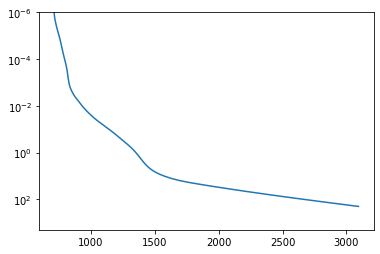

In [14]:
plt.ylim(2e3,1e-6)
plt.semilogy(temp,pressure)